In [42]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl
import re
from matplotlib import pyplot as plt
import json
from folium import plugins
import requests

# We import demographic data and clean and filter it

In [2]:
df = pd.read_csv('neighbourhood-profiles-2016-csv.csv')

In [3]:
dff = df.iloc[:,4:]

In [4]:
dff.head()

,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,Banbury-Don Mills,Bathurst Manor,Bay Street Corridor,Bayview Village,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,Neighbourhood Number,NaN,129,128,20,95,42,34,76,52,...,37,7,137,64,60,94,100,97,27,31
1,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526","27,695","15,873","25,797","21,396",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177","26,918","15,434","19,348","17,671",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,2.90%,2.80%,33.30%,21.10%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


In [5]:
df_f = dff.copy()
df_f.set_index('Characteristic', inplace = True)
df_f = df_f.transpose()

In [6]:
df_f.head()

Characteristic,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),...,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
City of Toronto,NaN,NaN,"2,731,571","2,615,060",4.50%,"1,179,057","1,112,929","4,334",630.2,"398,135",...,"59,945","2,556,120","1,516,110","1,040,015","639,060","400,950","184,120","141,135","42,985","216,835"
Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,"3,840",...,605,"27,490","18,865","8,610","5,445","3,170",880,735,135,"2,280"
Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,"3,075",...,490,"22,325","13,565","8,775","5,610","3,145",980,760,220,"2,170"
Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,"1,760",...,70,"11,370","8,235","3,130","2,200",925,680,615,70,245
Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,"2,360",...,835,"27,715","12,980","14,735","8,340","6,390","3,930","2,630","1,310","2,460"


In [7]:
df_f.head()

Characteristic,Neighbourhood Number,TSNS2020 Designation,"Population, 2016","Population, 2011",Population Change 2011-2016,Total private dwellings,Private dwellings occupied by usual residents,Population density per square kilometre,Land area in square kilometres,Children (0-14 years),...,External migrants,Total - Mobility status 5 years ago - 25% sample data,Non-movers,Movers,Non-migrants,Migrants,Internal migrants,Intraprovincial migrants,Interprovincial migrants,External migrants
City of Toronto,NaN,NaN,"2,731,571","2,615,060",4.50%,"1,179,057","1,112,929","4,334",630.2,"398,135",...,"59,945","2,556,120","1,516,110","1,040,015","639,060","400,950","184,120","141,135","42,985","216,835"
Agincourt North,129,No Designation,"29,113","30,279",-3.90%,"9,371","9,120","3,929",7.41,"3,840",...,605,"27,490","18,865","8,610","5,445","3,170",880,735,135,"2,280"
Agincourt South-Malvern West,128,No Designation,"23,757","21,988",8.00%,"8,535","8,136","3,034",7.83,"3,075",...,490,"22,325","13,565","8,775","5,610","3,145",980,760,220,"2,170"
Alderwood,20,No Designation,"12,054","11,904",1.30%,"4,732","4,616","2,435",4.95,"1,760",...,70,"11,370","8,235","3,130","2,200",925,680,615,70,245
Annex,95,No Designation,"30,526","29,177",4.60%,"18,109","15,934","10,863",2.81,"2,360",...,835,"27,715","12,980","14,735","8,340","6,390","3,930","2,630","1,310","2,460"


### Now we make one table for the ages and incomes for every neighbourhood

In [8]:
tor_age_inc = df_f[['Neighbourhood Number','Population, 2016','Population, 2011','Total private dwellings','Population density per square kilometre','Youth (15-24 years)','Working Age (25-54 years)','Pre-retirement (55-64 years)','Census families in private households by family size','  2 persons','  3 persons','  4 persons','  5 or more persons','  Couples without children','Total - Income statistics in 2015 for private households by household size - 100% data','  Median total income of households in 2015 ($)','  Median after-tax income of households in 2015 ($)']]

In [9]:
tor_demo = tor_age_inc.loc[:, ~tor_age_inc.columns.duplicated()]

In [10]:
tor_demo.fillna(0, inplace = True)
tor_demo.head()

c:\users\laptop\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Characteristic,Neighbourhood Number,"Population, 2016","Population, 2011",Total private dwellings,Population density per square kilometre,Youth (15-24 years),Working Age (25-54 years),Pre-retirement (55-64 years),Census families in private households by family size,2 persons,3 persons,4 persons,5 or more persons,Couples without children,Total - Income statistics in 2015 for private households by household size - 100% data,Median total income of households in 2015 ($),Median after-tax income of households in 2015 ($)
City of Toronto,0,"2,731,571","2,615,060","1,179,057","4,334","340,270","1,229,555","336,670","718,755","333,425","175,720","146,580","97,245","250,085","1,112,930","65,829","58,264"
Agincourt North,129,"29,113","30,279","9,371","3,929","3,705","11,305","4,230",8430,2370,1995,1750,1645,2520,"9,120",0,0
Agincourt South-Malvern West,128,"23,757","21,988","8,535","3,034","3,360","9,965","3,265",6650,2325,1680,1335,1175,2095,"8,130",0,0
Alderwood,20,"12,054","11,904","4,732","2,435","1,235","5,220","1,825",3480,1440,885,795,390,1175,"4,620",0,0
Annex,95,"30,526","29,177","18,109","10,863","3,750","15,040","3,480",6710,5220,1540,885,390,3830,"15,940",0,0


### We make a second table for the ethnicities of people in every neighbourhood

In [11]:
index_no = df_f.columns.get_loc('Total - Selected places of birth for the immigrant population in private households - 25% sample data')
index_no

1168

In [26]:
pl_of_birth = df_f.iloc[:,1169:1231]

In [27]:
pl_of_birth.head()

Characteristic,Americas,Brazil,Colombia,El Salvador,Guyana,Haiti,Jamaica,Mexico,Peru,Trinidad and Tobago,...,Pakistan,Philippines,Haiti,Sri Lanka,Syria,Taiwan,Viet Nam,Other places of birth in Asia,Scottish,Oceania and other places of birth
index,,,,,,,,,,,,,,,,,,,,,
City of Toronto,"212,010","7,025","8,715","6,955","34,490","1,850","45,075","7,225","3,870","19,640",...,"34,750","118,775",675,"52,900","5,575","7,695","30,580","52,450","256,250","3,780"
Agincourt North,"1,635",10,15,10,390,0,500,15,40,220,...,295,"1,180",0,"2,210",10,115,495,600,600,20
Agincourt South-Malvern West,"1,415",15,10,30,295,20,395,10,15,240,...,435,"1,030",15,"1,070",40,140,330,460,725,0
Alderwood,450,30,15,20,80,0,45,25,0,50,...,15,420,0,25,0,0,35,85,"1,720",10
Annex,"1,630",60,40,10,45,0,175,60,60,80,...,135,175,0,30,20,120,70,515,"5,225",85


#### Now we work on visualizing this data

We need to aggregate all African countries since that column appears to be missing

In [28]:
pl_of_birth['Africa'] = 0
africa = pl_of_birth[['    Algeria', '    Egypt',
       '    Ethiopia', '    Kenya', '    Morocco', '    Nigeria',
       '    Somalia', '    South Africa; Republic of',
       '    Other places of birth in Africa']]

for country in africa:
    africa[country] = africa[country].str.replace(',', '').astype(int)
    
pl_of_birth['Africa'] = africa.sum(axis = 1)

In [29]:
pl_of_birth.head()

Characteristic,Americas,Brazil,Colombia,El Salvador,Guyana,Haiti,Jamaica,Mexico,Peru,Trinidad and Tobago,...,Philippines,Haiti,Sri Lanka,Syria,Taiwan,Viet Nam,Other places of birth in Asia,Scottish,Oceania and other places of birth,Africa
index,,,,,,,,,,,,,,,,,,,,,
City of Toronto,"212,010","7,025","8,715","6,955","34,490","1,850","45,075","7,225","3,870","19,640",...,"118,775",675,"52,900","5,575","7,695","30,580","52,450","256,250","3,780",77450
Agincourt North,"1,635",10,15,10,390,0,500,15,40,220,...,"1,180",0,"2,210",10,115,495,600,600,20,455
Agincourt South-Malvern West,"1,415",15,10,30,295,20,395,10,15,240,...,"1,030",15,"1,070",40,140,330,460,725,0,355
Alderwood,450,30,15,20,80,0,45,25,0,50,...,420,0,25,0,0,35,85,"1,720",10,95
Annex,"1,630",60,40,10,45,0,175,60,60,80,...,175,0,30,20,120,70,515,"5,225",85,645


We convert all values in our dataframe to int

In [30]:
for conti in pl_of_birth:
    if isinstance(pl_of_birth[conti], pd.Series):
        if pl_of_birth[conti].dtype == object:
            pl_of_birth[conti] = pl_of_birth[conti].str.replace(',', '').astype(int)
        else:
            pass
    else:
         pl_of_birth[conti] = pl_of_birth[conti].sum(axis = 1)
   

Now we import in the neighbourhood data FOR THE 140 ADMINISTRATIVE NEIGHBOURHOODS:

In [38]:
tor_ngh_data = pd.read_csv('tor_neighbourhood_locations.csv')
tor_ngh_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [39]:
tor_ngh_data.head()

,Borough,Location,Latitude,Longitude,Neighbourhoods covered
0,Scarborough,Agincourt North,43.808038,-79.266439,Agincourt and Brimwood
1,Scarborough,Agincourt South-Malvern West,43.781969,-79.257689,Agincourt and Malvern
2,Etobicoke,Alderwood,43.601717,-79.545232,Alderwood
3,Old City of Toronto,Annex,43.670338,-79.407117,The Annex and Seaton Village
4,North York,Banbury-Don Mills,43.670338,-79.407117,Don Mills


Now we move onto the foursquare data:

In [56]:
def get_all_venues(latitude, longitude, neighbourhood, borough):
    
    final_dff = []
    
    CLIENT_ID ='WU2R1DNGLYATXFKLN5ITK0HXJEZR3YGYLXLUJTAY3VHPL53Z' 
    CLIENT_SECRET = 'GGGU5VRJL14XJBW3X3AN0VX50UO3GSSD1OS3X5BECJ0X5KC4' 
    ACCESS_TOKEN = 'ZDDLZJZUUWYMMU0151BLSD5BKBY5Z01D2P0LBO0UGV0VZ55Q' 
    VERSION = '20210813' 
    LIMIT = 150 
    radius = 500

    for lat, lng, ngh, bor in zip(latitude, longitude, neighbourhood, borough):
        neighborhood_latitude = lat
        neighborhood_longitude = lng
        neighborhood_name = ngh 
    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        try:
            for ra in range(len(results)):
                row = {
                   'Neighbourhood':ngh, 'Borough': bor, 'Neighbourhood_Latitude':lat,'Neighbourhood_Longitude':lng,
                   'Venue':results[ra]['venue']['name'],'Venue_Latitude':results[ra]['venue']['location']['lat'],
                   'Venue_Longitude':results[ra]['venue']['location']['lng'],
                   'Venue_Category':results[ra]['venue']['categories'][0]['name']
               }
                final_dff.append(row)
                
        except Exception as err:
            print('Error occured:', err, ', skip row')
    
    ret_df = pd.DataFrame(final_dff)
    return ret_df

In [57]:
tor_venues = get_all_venues(tor_ngh_data['Latitude'], tor_ngh_data['Longitude'], tor_ngh_data['Location'], tor_ngh_data['Borough'])

In [58]:
tor_venues.head()

,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Agincourt North,Scarborough,43.808038,-79.266439,Menchie's,43.808338,-79.268288,Frozen Yogurt Shop
1,Agincourt North,Scarborough,43.808038,-79.266439,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
2,Agincourt North,Scarborough,43.808038,-79.266439,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
3,Agincourt North,Scarborough,43.808038,-79.266439,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
4,Agincourt North,Scarborough,43.808038,-79.266439,Booster Juice,43.809915,-79.269382,Juice Bar


We find all the resturants

In [60]:
resturants = tor_venues.loc[tor_venues['Venue_Category'].str.contains('Restaurant')]

In [61]:
resturants.tail()

,Neighbourhood,Borough,Neighbourhood_Latitude,Neighbourhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
2832,York University Heights,North York,43.758781,-79.519434,Pita Land,43.757520,-79.514628,Falafel Restaurant
2838,Yorkdale-Glen Park,North York,43.703434,-79.452918,McDonald's,43.704919,-79.452238,Fast Food Restaurant
2839,Yorkdale-Glen Park,North York,43.703434,-79.452918,Sky Ranch Restaurant,43.700730,-79.451684,Argentinian Restaurant
2841,Yorkdale-Glen Park,North York,43.703434,-79.452918,Darosa,43.706970,-79.453121,Mediterranean Restaurant
2845,Yorkdale-Glen Park,North York,43.703434,-79.452918,Il vagabondo,43.701480,-79.452443,Italian Restaurant


In [62]:
resturants.shape

(744, 8)

According to the above, there are 744 separate entries.

Now we groupby neighbourhood to see what the layout is:

In [104]:
restaurant_sort = (
    resturants
    .groupby(['Neighbourhood', 'Borough'], as_index = False)
    .agg(Total = ('Venue', 'count'))
    .sort_values('Total', ascending = True)
)    
#resturant_sort = resturants.groupby(['Neighbourhood', 'Borough']).count().sort_values(by = 'Venue', ascending = False)

In [128]:
restaurant_sort.tail(10)

,Neighbourhood,Borough,Total
60,Playter Estates-Danforth,Old City of Toronto,16
95,Wychwood,Old City of Toronto,17
97,Yonge-St.Clair,Old City of Toronto,19
20,Dufferin Grove,Old City of Toronto,20
96,Yonge and Eglinton,Old City of Toronto,20
43,Milliken,Scarborough,21
28,Hillcrest Village,North York,22
11,Church-Yonge Corridor,Old City of Toronto,25
12,Clairlea-Birchmount,Scarborough,25
4,Bay Street Corridor,Old City of Toronto,31


In [130]:
restaurant_sort.loc[restaurant_sort['Total'] <= 5].count()

Neighbourhood    56
Borough          56
Total            56
dtype: int64

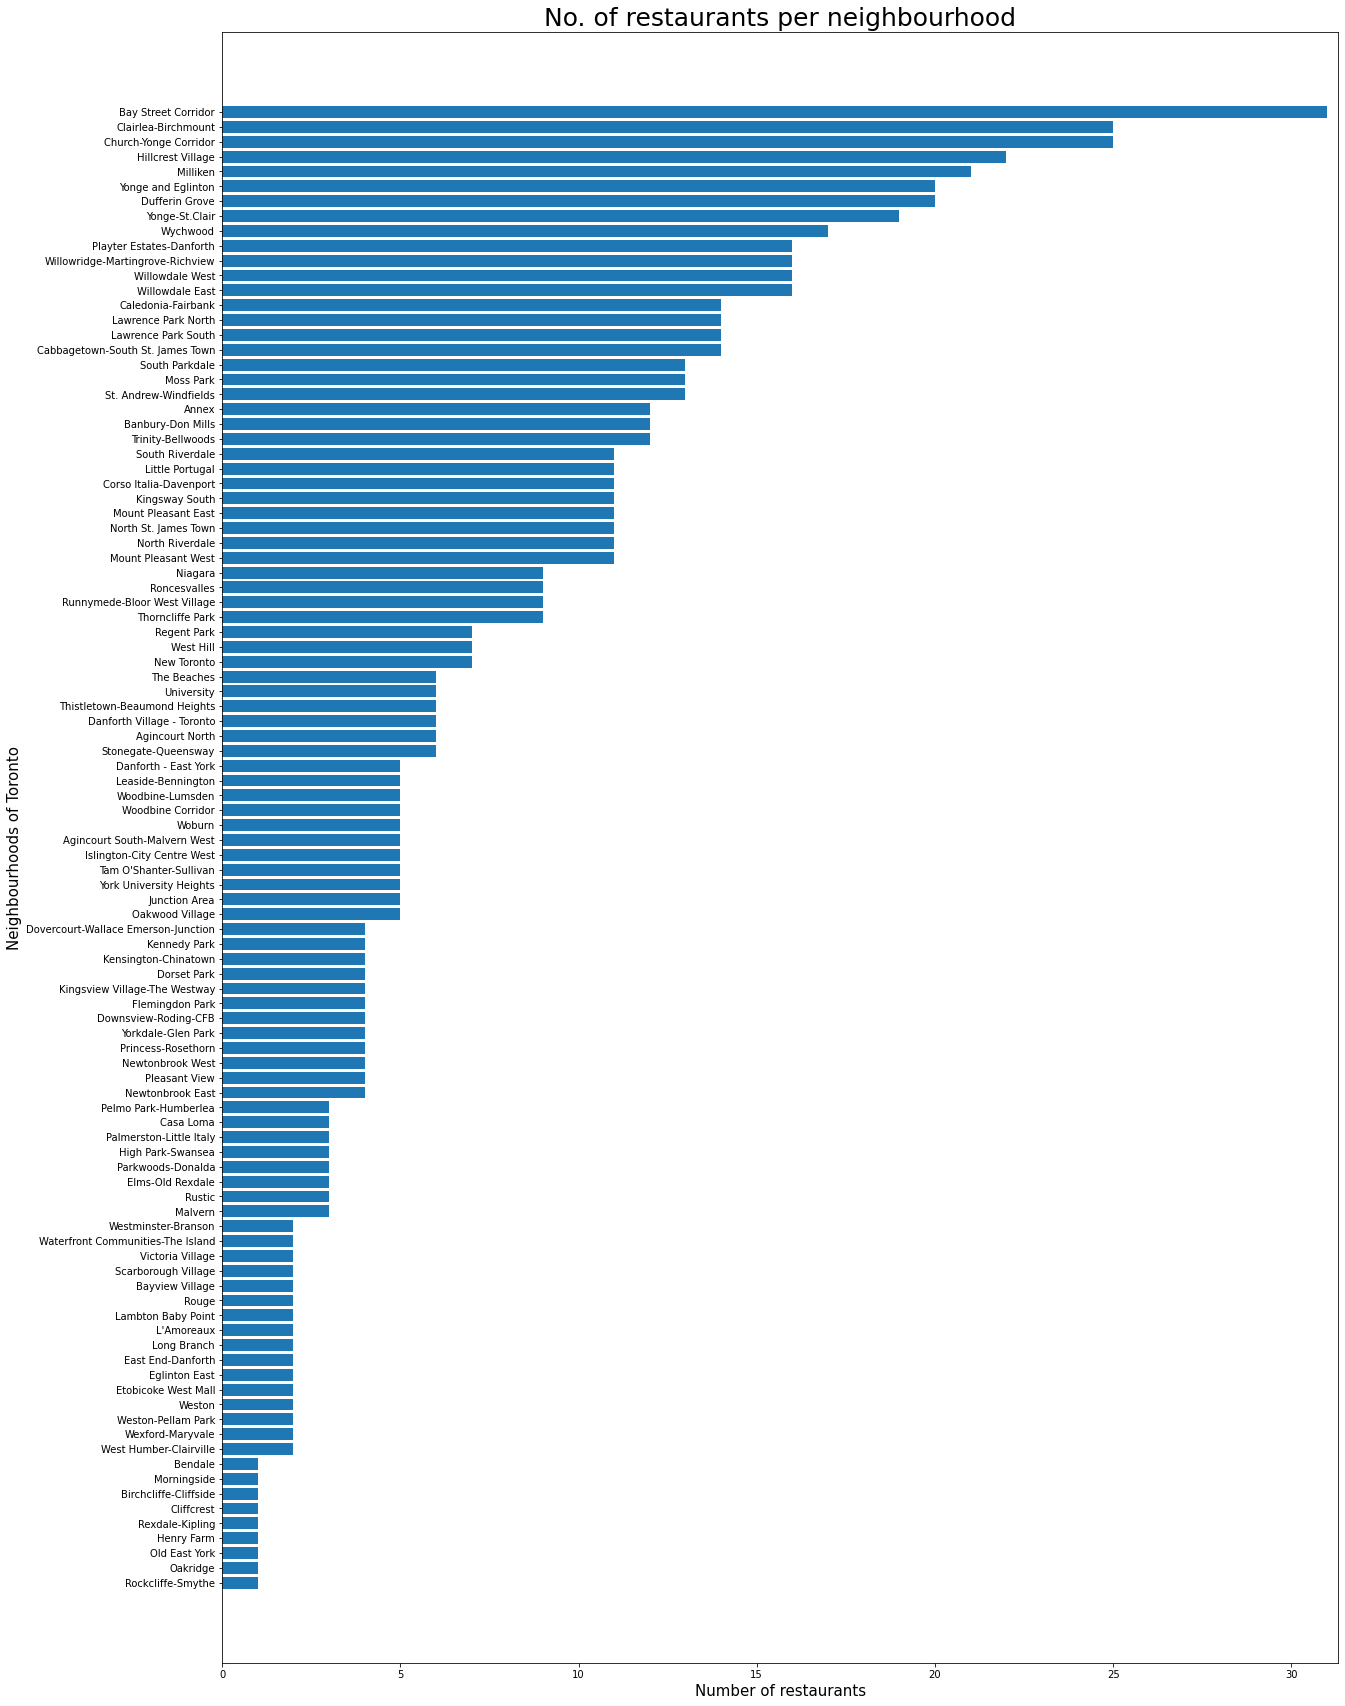

In [106]:
plt.figure(figsize = (20, 30))
plt.margins(0.01, 0.05)
plt.barh(restaurant_sort['Neighbourhood'], restaurant_sort['Total'])
#plt.xticks(rotation = 90)
plt.ylabel('Neighbourhoods of Toronto', fontdict = {'fontsize': 15})
plt.xlabel('Number of restaurants', fontdict = {'fontsize': 15})
plt.title('No. of restaurants per neighbourhood', fontdict = {'fontsize': 25})
plt.show()

In [109]:
restaurant_sort.sort_values(by = 'Total', ascending = False).head(10)

,Neighbourhood,Borough,Total
4,Bay Street Corridor,Old City of Toronto,31
12,Clairlea-Birchmount,Scarborough,25
11,Church-Yonge Corridor,Old City of Toronto,25
28,Hillcrest Village,North York,22
43,Milliken,Scarborough,21
96,Yonge and Eglinton,Old City of Toronto,20
20,Dufferin Grove,Old City of Toronto,20
97,Yonge-St.Clair,Old City of Toronto,19
95,Wychwood,Old City of Toronto,17
91,Willowridge-Martingrove-Richview,Etobicoke,16


Above we have a visual representation of the neighbourhoods with the greatest number of restaurants, and below that a table showing the top ten neighbourhoods in terms of number of restaurants. 

We can also look at the borough with the greatest number of neighbourhoods having restaurants:

In [126]:
restaurant_sort.groupby(['Borough']).count().sort_values(by = 'Total', ascending = False).head(5)

,Neighbourhood,Total
Borough,,
Old City of Toronto,38,38
Scarborough,20,20
North York,19,19
Etobicoke,13,13
East York,5,5


The above shows the neighbourhoods and the boroughs with the greatest number of restaurants. Opening a restaurant in the above locales would likely be successful.

However, it takes more than just the presence of other restaurants to make it successful. We also need to see what type of restaurants are present in each neighbourhood, as it could be be that restaurants of a particular cusine that are successful in certain locales, and opening restaurants of a different type might not be that successful. [Dummies and clusters, with each cluster representing the most popular restaurant type in the neighbourhood]

Another thing to check is the locations of all these restaurants on a map. A cluster of restaurants might indicate a popular food street (where opening a restaurant would certainly be helpful), while an isolated restaurant could indicate the skill of the restauranters, and a new establishment might struggle based on their services. [Map, possible bar chart of ethinicities]

The income of the surrounding neighbourhoods would also be imperative, as a restaurant in an upscale locale would certainly be more expensive than one which isn't in such an upscale neighbourhood. [Income chart]